In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [37]:
# Part 1: Dataset Import and Preprocessing
data = pd.read_csv('data_4.csv')

# Display information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28458 entries, 0 to 28457
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 28458 non-null  int64  
 1   id.resp_p                 28458 non-null  int64  
 2   proto                     28458 non-null  object 
 3   service                   28458 non-null  object 
 4   flow_duration             28458 non-null  float64
 5   fwd_pkts_tot              28458 non-null  int64  
 6   bwd_pkts_tot              28458 non-null  int64  
 7   fwd_data_pkts_tot         28458 non-null  int64  
 8   bwd_data_pkts_tot         28458 non-null  int64  
 9   fwd_pkts_per_sec          28458 non-null  float64
 10  bwd_pkts_per_sec          28458 non-null  float64
 11  flow_pkts_per_sec         28458 non-null  float64
 12  down_up_ratio             28458 non-null  float64
 13  fwd_header_size_tot       28458 non-null  int64  
 14  fwd_he

In [38]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 id.orig_p               0
id.resp_p               0
proto                   0
service                 0
flow_duration           0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 84, dtype: int64


In [39]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns

# Process numeric columns only for IQR outlier detection
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
outlier_condition = (data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))
print("Outliers detected per column:\n", outlier_condition.sum())


Outliers detected per column:
 id.orig_p                359
id.resp_p               3893
flow_duration           6046
fwd_pkts_tot             614
bwd_pkts_tot            2157
                        ... 
idle.avg                5697
idle.std                1017
fwd_init_window_size       0
bwd_init_window_size       0
fwd_last_window_size    1400
Length: 81, dtype: int64


### If I drop all identified outliers that would effect the performance of the modal significantly. Therefore, I just leave them for better learning and for avoiding overfitting.

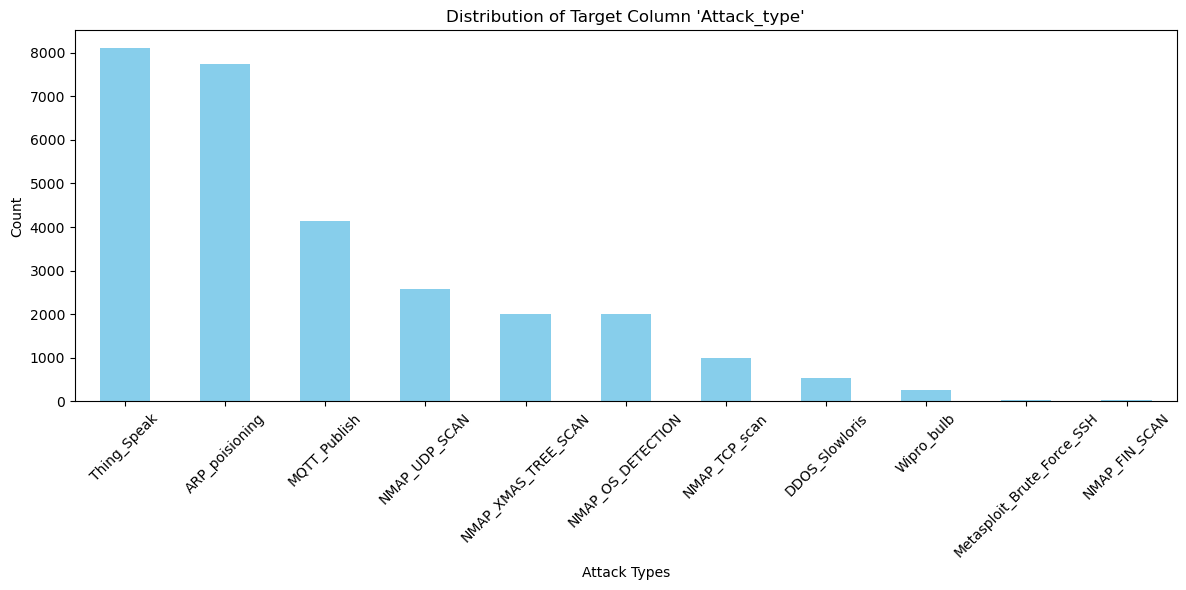

In [40]:
# Attack_type is my target column so I will visualize it.
plt.figure(figsize=(12, 6))
data['Attack_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Target Column 'Attack_type'")
plt.xlabel("Attack Types")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Encoding categorical features 
categorical_cols = data.select_dtypes(include=['object']).columns

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28458 entries, 0 to 28457
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 28458 non-null  int64  
 1   id.resp_p                 28458 non-null  int64  
 2   proto                     28458 non-null  int32  
 3   service                   28458 non-null  int32  
 4   flow_duration             28458 non-null  float64
 5   fwd_pkts_tot              28458 non-null  int64  
 6   bwd_pkts_tot              28458 non-null  int64  
 7   fwd_data_pkts_tot         28458 non-null  int64  
 8   bwd_data_pkts_tot         28458 non-null  int64  
 9   fwd_pkts_per_sec          28458 non-null  float64
 10  bwd_pkts_per_sec          28458 non-null  float64
 11  flow_pkts_per_sec         28458 non-null  float64
 12  down_up_ratio             28458 non-null  float64
 13  fwd_header_size_tot       28458 non-null  int64  
 14  fwd_he

In [43]:
# from sklearn.feature_selection import VarianceThreshold

# def remove_low_variance_columns(data, threshold=0.01):
#     """
#     Drops slightly correlated columns
#     threshold: Variance is the lower limit.
#     """
#     selector = VarianceThreshold(threshold=threshold)
#     selector.fit(data.select_dtypes(include=['number']))
#     low_variance_cols = data.select_dtypes(include=['number']).columns[~selector.get_support()]
#     print(f"Dropped columns(low variance): {list(low_variance_cols)}")
#     return data.drop(columns=low_variance_cols)


# def remove_low_correlation_columns(data, threshold=0.1):
#     """
#       By calculating the average correlation between all columns
#       removes columns with low correlation.
#       threshold: Correlation threshold value (if the average correlation is below this value, the column is omitted).
#     """
#     # Numeric data
#     numeric_data = data.select_dtypes(include=['number'])
    
#     # Corelation matrix
#     corr_matrix = numeric_data.corr()
    
#     # Calculating average corelation among columns
#     mean_correlation = corr_matrix.mean()
    
#     # Find lower corelations
#     low_corr_cols = mean_correlation[mean_correlation.abs() < threshold].index
#     print(f"Dropped columns: {list(low_corr_cols)}")
    
#     # Drop those columns
#     return data.drop(columns=low_corr_cols)


# # 4. Merged cleaned dataset
# def clean_dataset(data):
#     data_cleaned = remove_low_variance_columns(data, threshold=0.01)
#     data_cleaned = remove_low_correlation_columns(data_cleaned, threshold=0.1)
#     print(f"Remaining columns: {data_cleaned.columns.tolist()}")
#     return data_cleaned

# # Load the updated data
# data_cleaned = clean_dataset(data)

# # Cleaned data
# print("Cleaned dataset:")
# print(data_cleaned.head())

In [44]:
# Normalize/Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

In [45]:
# Compute the correlation matrix for numeric features
numeric_cols = data_scaled.select_dtypes(include=['number']).columns
correlation_matrix = data_scaled[numeric_cols].corr()
# I can't show correlation matrix heatmap since there are too many columns.

In [46]:
print(data.columns)

Index(['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       '

In [47]:
target_column = 'Attack_type'  

# Split data into features (X) and target (y)
X = data_scaled.drop(target_column, axis=1, errors='ignore')  # Features
y = data[target_column]  # Target column

# Train-Test Split for Classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("K-Nearest Neighbors Report:\n", classification_report(y_test, y_pred_knn))


c:\Users\Arda Deniz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      2333
           1       0.94      0.80      0.86       168
           2       1.00      1.00      1.00      1246
           3       0.92      0.79      0.85        14
           4       0.78      0.78      0.78         9
           5       1.00      1.00      1.00       591
           6       1.00      0.99      0.99       281
           7       0.96      0.99      0.97       769
           8       1.00      1.00      1.00       616
           9       0.91      0.97      0.94      2430
          10       0.96      0.65      0.78        81

    accuracy                           0.95      8538
   macro avg       0.95      0.90      0.92      8538
weighted avg       0.95      0.95      0.95      8538

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2333
           1       0.97   

<Figure size 800x600 with 0 Axes>

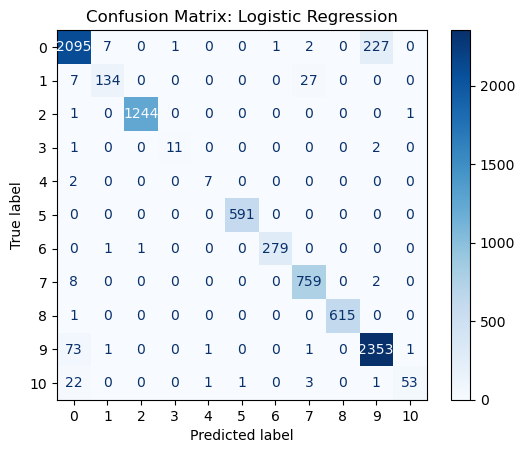

<Figure size 800x600 with 0 Axes>

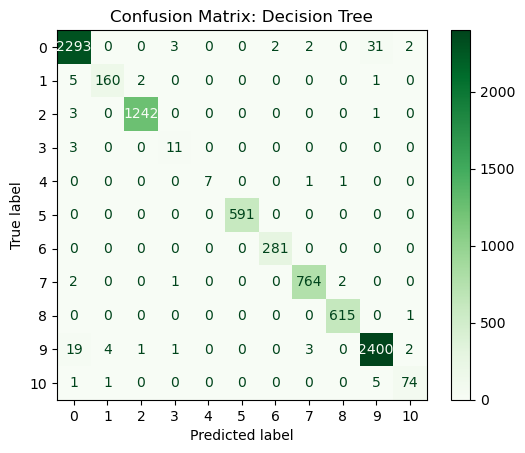

<Figure size 800x600 with 0 Axes>

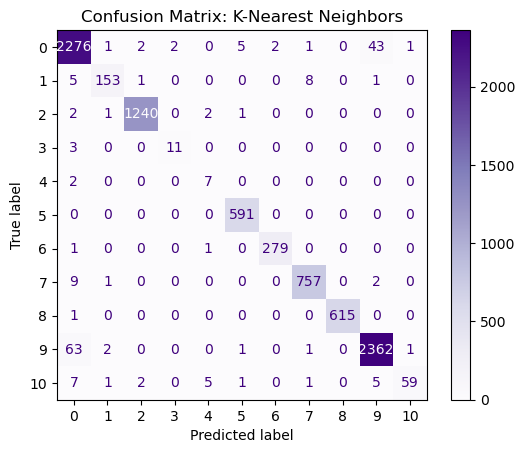

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr.classes_)
disp_lr.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_)
disp_dt.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix: Decision Tree")
plt.show()

# Plot confusion matrix for K-Nearest Neighbors
plt.figure(figsize=(8, 6))
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp_knn.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix: K-Nearest Neighbors")
plt.show()


# Classification Algorithms
## Logistic Regression:

### Strengths: Best suited for linearly separable datasets.
### Weaknesses: Struggles with complex, non-linear relationships and imbalanced data.
### Performance Notes: Misclassification is notable for minority or boundary cases, especially for certain classes like 9.

## Decision Tree:

### Strengths: Good at handling non-linear patterns; highly interpretable.
### Weaknesses: Tends to overfit, particularly in imbalanced datasets.
### Performance Notes: Effective for major classes (0 and 9) but less reliable for minority classes.

## k-Nearest Neighbors (kNN):

### Strengths: Does not require a training phase; simple and effective for normalized data.
### Weaknesses: Computationally expensive, struggles with high-dimensional data or noisy inputs.
### Performance Notes: Retains more true positives for challenging classes compared to Logistic Regression.

Explained Variance by PCA Components: [0.18769557 0.14291148]


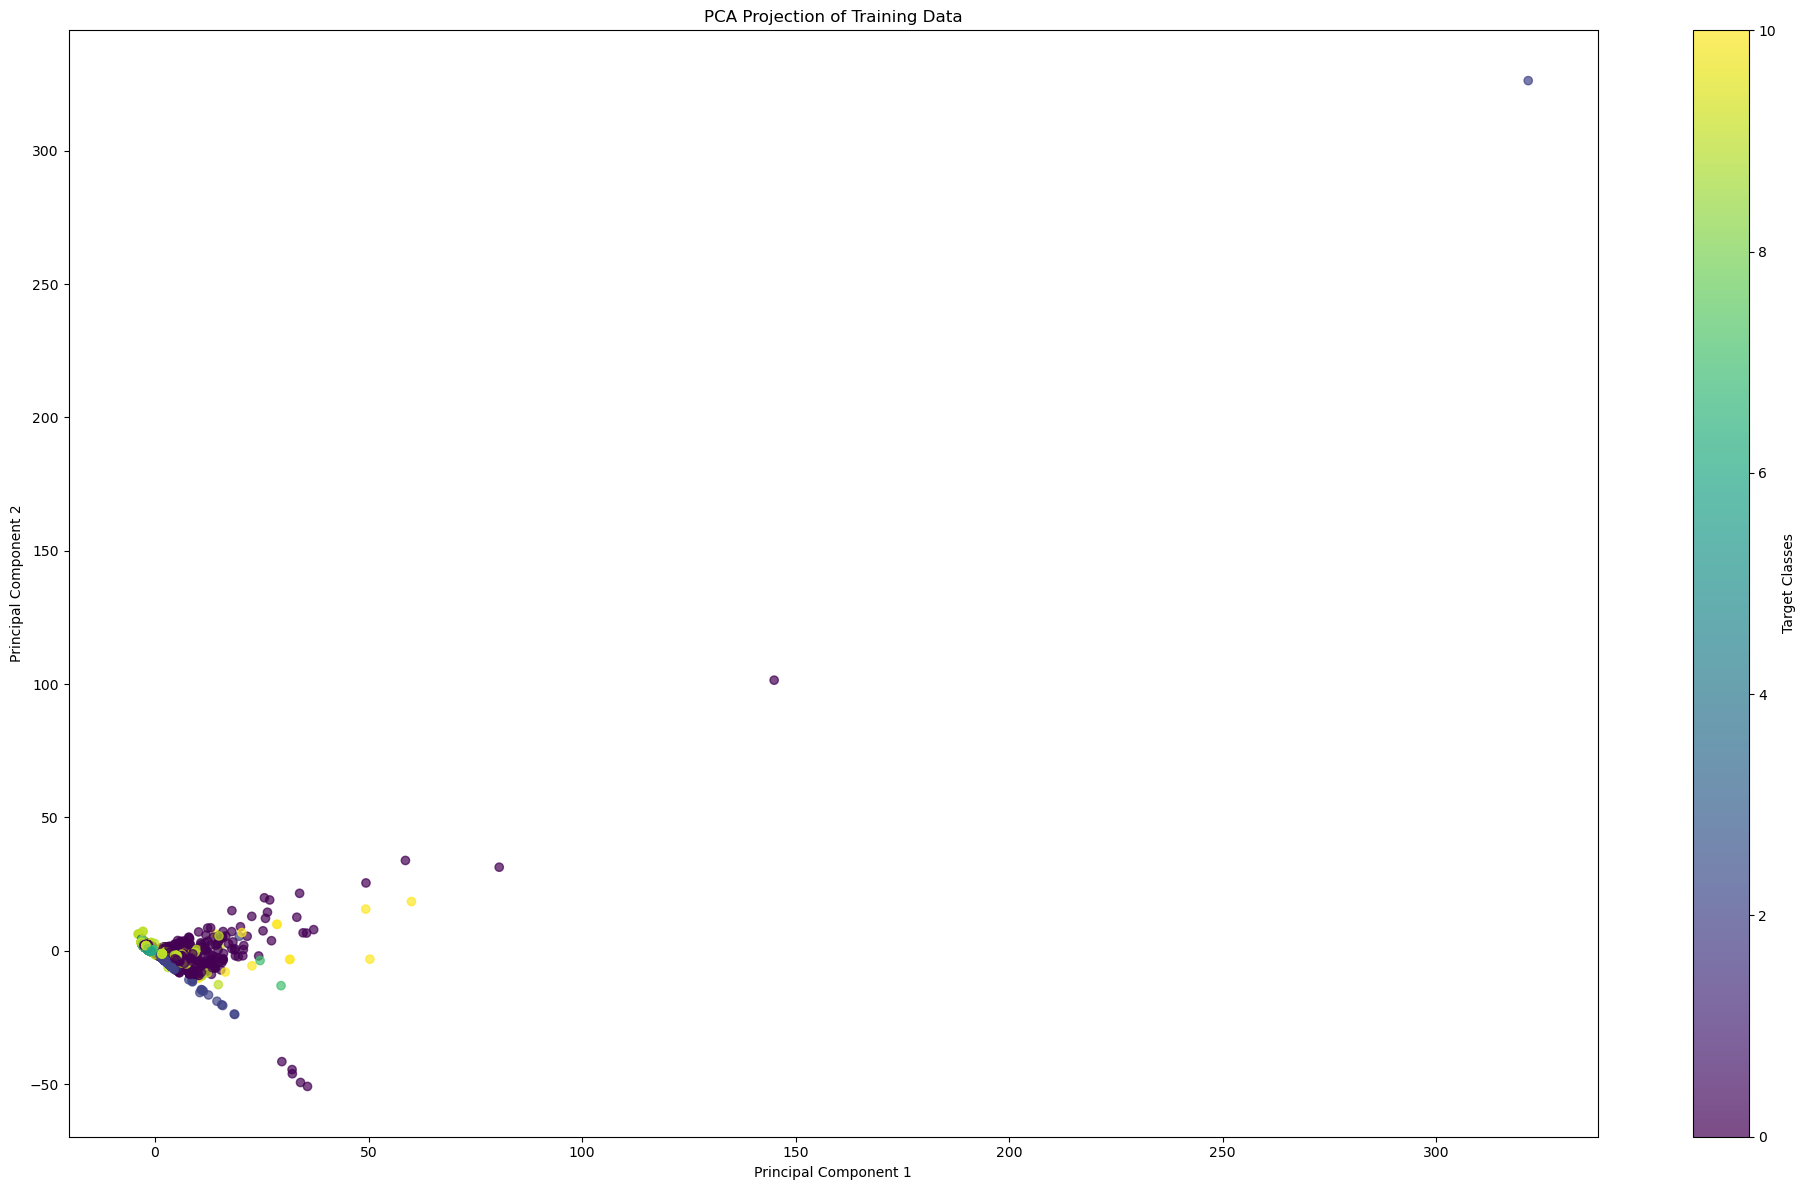

In [49]:
# PCA for Dimensionality Reduction Before Clustering
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization and clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PCA Components: {explained_variance}")

# Scatter plot of the reduced dimensions
plt.figure(figsize=(20, 12))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, c=y_train, cmap='viridis')
plt.title("PCA Projection of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Target Classes')
plt.tight_layout()
plt.show()

In [50]:
# Clustering Algorithms (Unsupervised)
# K-Means
for n_clusters in range(3, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans_labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, kmeans_labels)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score}")

# DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 15, 20]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)
        score = silhouette_score(X_pca,dbscan_labels)
        print(f"EPS: {eps}, Min Samples: {min_samples}, Silhouette Score: {score}")


#Agglomerative clustering
linkage_methods = ['ward', 'average', 'complete', 'single']

for linkage in linkage_methods:
    for n_clusters in range(3, 12):
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agglo_labels = agglo.fit_predict(X_pca)
        score = silhouette_score(X_pca, agglo_labels)
        print(f"Linkage: {linkage}, Clusters: {n_clusters}, Silhouette Score: {score}")



Clusters: 3, Silhouette Score: 0.7176130043150366
Clusters: 4, Silhouette Score: 0.7321816795552822
Clusters: 5, Silhouette Score: 0.7267138492233248
Clusters: 6, Silhouette Score: 0.7024861951627825
Clusters: 7, Silhouette Score: 0.6744597281463329
Clusters: 8, Silhouette Score: 0.7147637174564498
Clusters: 9, Silhouette Score: 0.6714799250705721
Clusters: 10, Silhouette Score: 0.6951325637909024
Clusters: 11, Silhouette Score: 0.7203370752917997
Clusters: 12, Silhouette Score: 0.7068023850134035
Clusters: 13, Silhouette Score: 0.6930786854187496
Clusters: 14, Silhouette Score: 0.7162326280502224
EPS: 0.3, Min Samples: 5, Silhouette Score: 0.2833498417247074
EPS: 0.3, Min Samples: 10, Silhouette Score: 0.3736818199420299
EPS: 0.3, Min Samples: 15, Silhouette Score: 0.4515660208202686
EPS: 0.3, Min Samples: 20, Silhouette Score: 0.21533993189886175
EPS: 0.5, Min Samples: 5, Silhouette Score: 0.41667991007018373
EPS: 0.5, Min Samples: 10, Silhouette Score: 0.605969421460884
EPS: 0.5, Mi

### I have come up with the parameters for the clustering algorithms which are more compatible for PAC(Probably Approximately Correct) accuracy .

In [51]:
# Clustering Algorithms (Unsupervised)
# K-Means
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(X_pca)
print("K-Means Silhouette Score:", silhouette_score(X_pca, kmeans_labels))

# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)
print("DBSCAN Silhouette Score:", silhouette_score(X_pca, dbscan_labels))

# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=4, linkage= 'single')
agglo_labels = agglo.fit_predict(X_pca)
print("Agglomerative Clustering Silhouette Score:", silhouette_score(X_pca, agglo_labels))

K-Means Silhouette Score: 0.659019291893484
DBSCAN Silhouette Score: 0.614206662493034
Agglomerative Clustering Silhouette Score: 0.9497607131385187


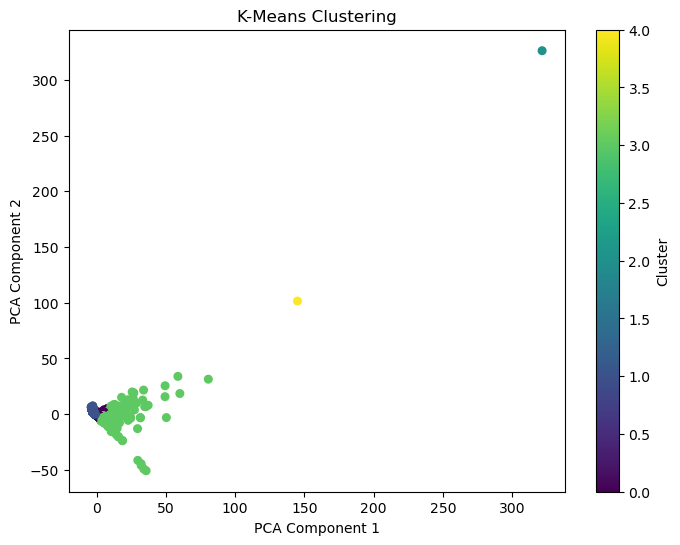

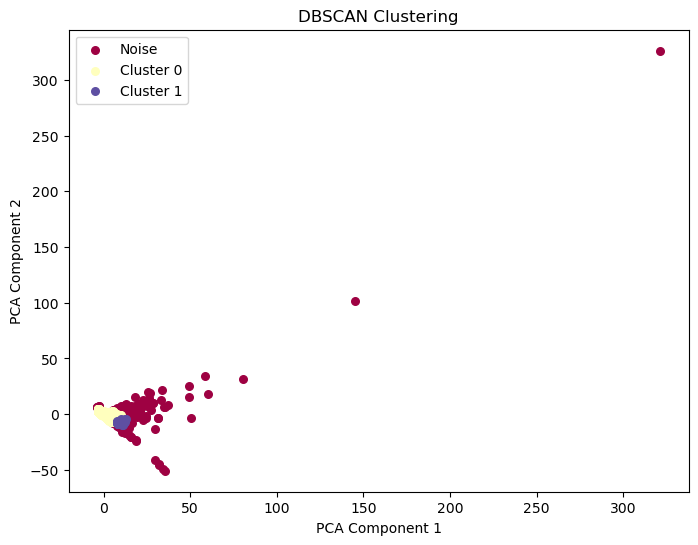

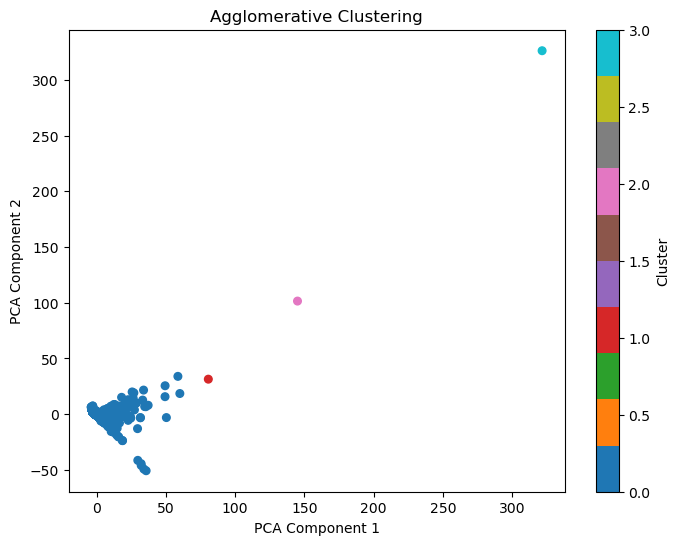

In [ ]:
# Plot K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Plot DBSCAN Clusters
dbscan_unique_labels = np.unique(dbscan_labels)
dbscan_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(dbscan_unique_labels))]
plt.figure(figsize=(8, 6))
for label, color in zip(dbscan_unique_labels, dbscan_colors):
    mask = dbscan_labels == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=color, s=30, label=f"Cluster {label}" if label != -1 else "Noise")
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# Plot Agglomerative Clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='tab10', s=30)
plt.title("Agglomerative Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


# Clustering Algorithms
## k-Means:

### Strengths: Efficient for compact, spherical clusters; fast convergence.
### Weaknesses: Poor handling of outliers, fails on datasets with clusters varying in size or density.
### Performance Notes: Struggles with noise and high PCA component values.

## DBSCAN:

### Strengths: Robust against noise, handles arbitrary cluster shapes.
### Weaknesses: Sensitive to hyperparameter tuning.
### Performance Notes: Excels in noisy or irregularly shaped clusters, though may merge smaller ones.

## Agglomerative Clustering:

### Strengths: Reveals hierarchical cluster relationships; good for compact clusters.
### Weaknesses: High computational cost for large datasets, sensitive to "linkage method" selection.
### Performance Notes: Offers valuable insights but requires careful parameter adjustment.

# Comparison and Analysis

## Classification:
### For Complex Data: Use Decision Trees for their adaptability and interpretability, being cautious of overfitting.
### For Linear Simplicity: Optimal for Logistic Regression when the data exhibits linear patterns and is well-balanced.

## Clustering:
### For Noisy, Arbitrary Clusters: Choose DBSCAN to handle noise effectively and non-spherical cluster structures.
### For Spherical, Compact Clusters: Choose k-Means, especially when computational efficiency is a priority and outliers are minimal.
### If computational resources are not a constraint, Agglomerative Clustering is indeed the best choice for our dataset. It provides:

#### High accuracy in separating clusters.
#### Insights into hierarchical relationships.
#### Robustness to varying densities and shapes.